In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.stats import entropy
import glob
import matplotlib.pyplot as plt
from Cryptodome.PublicKey import RSA
from Cryptodome.Cipher import PKCS1_OAEP
import hashlib


In [2]:
imdir = (r"C:\Users\Limak\Desktop\Projekt 2\data\*")
ext = ['png', 'jpg', 'gif', 'bmp']    # Add image formats here

files = []
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]
images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in files]

In [3]:
shapes = set()
for im in images:
    shapes.add(im.shape)
print(shapes)

{(160, 160)}


(160, 160)


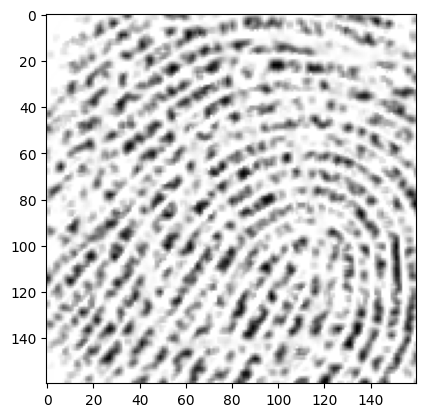

In [4]:
im = images[0]
print(im.shape)
plt.imshow(im, cmap='gray');

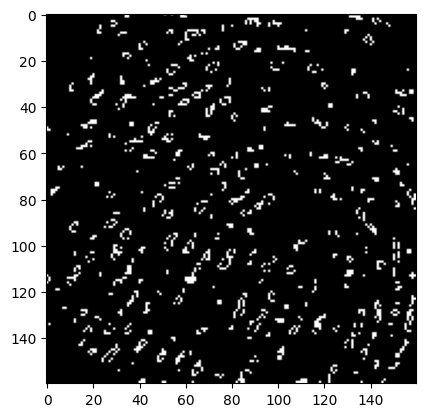

In [5]:
imf = im.flatten().astype(np.uint8)
mask = (im > 80) & (im < 120)
maskf = mask.flatten().astype(np.uint8)
imt = mask.astype(np.uint8)
plt.imshow(imt, cmap='gray');

In [6]:
maskr = mask.ravel()
im_buffer = imf
im_buffer_len = len(im_buffer)
temp_buffer = np.empty_like(maskr, dtype=np.uint8)
im_height, im_width = im.shape
for i in range(im_buffer_len):
    if maskr[i]:
        temp_buffer[i]= np.uint8(im_buffer[i]) ^ np.uint8(i % im_width) ^ np.uint8(i / im_width)

random_number_buffer = np.empty(shape=(len(maskr)//2,), dtype=np.uint8)
for i in range(len(random_number_buffer)):
    random_number_buffer[i] = temp_buffer[2 * i]
    rval = random_number_buffer[i]
    tval = temp_buffer[2*i+1]
    random_number_buffer[i] = np.bitwise_or(
        (np.left_shift(np.uint8(rval), np.uint8(4))), 
        np.bitwise_and(np.uint8(tval),np.uint8(0x0f))
    )

# print(random_number_buffer)
# print(set(random_number_buffer))
# print()
# import collections
# counter = collections.Counter(random_number_buffer)
# print(*zip(counter.keys(), counter.values()))
# print()
# print(counter.keys())
# print(random_number_buffer.shape)

In [7]:
from tqdm.notebook import tqdm
import multiprocessing as mp
def process_image(im):
    imf = im.flatten().astype(np.uint8)
    mask = (im > 120) & (im < 255 - 8)
#     mask = (im > 60) & (im < 80)
    maskr = mask.ravel()
    im_buffer = imf
    im_buffer_len = len(im_buffer)
    temp_buffer = np.empty_like(maskr, dtype=np.uint8)
    im_height, im_width = im.shape
#     im_width //= 2
    for i in range(im_buffer_len):
        if maskr[i]:
            temp_buffer[i] = np.bitwise_xor(np.uint8(im_buffer[i]),np.bitwise_xor(np.uint8(i % im_width), np.uint8(i / im_width)))
#             temp_buffer[i] = np.uint8(im_buffer[i]) 
    random_number_buffer = np.empty(shape=(len(maskr)//2,), dtype=np.uint8)
    # trik2
    offset = 0
    # /trik2
    for i in range(len(random_number_buffer)):
        random_number_buffer[i] = temp_buffer[2 * i]
#         # trik1
#         if random_number_buffer[i] == 0 or random_number_buffer[i] == 1 or temp_buffer[2*i+1] == 0 or temp_buffer[2*i+1] == 1:
#             random_number_buffer[i] = np.random.randint(128,255)
#             temp_buffer[2*i+1] = np.random.randint(0, 255)
#         # /trik1
        # trik2
        if random_number_buffer[i] == 0 or random_number_buffer[i] == 1 or temp_buffer[2*i+1] == 0 or temp_buffer[2*i+1] == 1:
            continue
        offset += 1
        # /trik2
        random_number_buffer[i] = np.bitwise_or(
            (np.left_shift(np.uint8(random_number_buffer[i]), np.uint8(4))), 
            np.bitwise_and(np.uint8(temp_buffer[2*i+1]),np.uint8(0x0f))
        )
    return random_number_buffer[:offset]




In [8]:
from tqdm.notebook import tqdm
import multiprocessing as mp
def process_image(im):
    imf = im.flatten().astype(np.uint8)
    mask = (im > 8) & (im < 255 - 8)
    maskr = mask.ravel()
    im_buffer = imf
    im_buffer_len = len(im_buffer)
    temp_buffer = np.empty_like(maskr, dtype=np.uint8)
    im_height, im_width = im.shape
    for i in range(im_buffer_len):
        if maskr[i]:
            temp_buffer[i] = np.bitwise_xor(np.uint8(im_buffer[i]),np.bitwise_xor(np.uint8(i % im_width), np.uint8(i / im_width)))
    random_number_buffer = np.empty(shape=(len(maskr)//2,), dtype=np.uint8)
    offset = 0
    for i in range(len(random_number_buffer)):
#         random_number_buffer[i] = temp_buffer[2 * i]
        if temp_buffer[2 * i] == 0 or temp_buffer[2 * i] == 1 or temp_buffer[2*i+1] == 0 or temp_buffer[2*i+1] == 1 or temp_buffer[2 * i] == 4 or temp_buffer[2 * i] == 16 or temp_buffer[2*i+1] == 4 or temp_buffer[2*i+1] == 16:
#         if temp_buffer[2 * i] == 0 or temp_buffer[2*i+1] == 0:
            continue
        random_number_buffer[offset] = temp_buffer[2 * i]
        random_number_buffer[offset] = np.bitwise_or(
            (np.left_shift(np.uint8(random_number_buffer[offset]), np.uint8(4))), 
            np.bitwise_and(np.uint8(temp_buffer[2*i+1]),np.uint8(0x0f))
        )
        offset += 1
        
    return random_number_buffer[:offset]




In [9]:
def gen_multi(images):
    with mp.Pool() as pool:
        buffer = pool.map(process_image, images)
    return np.array(buffer).flatten()

# def gen_single(images):
#     buffer = []
#     for im in tqdm(images):
#         buffer.append(process_image(im))
#     return np.array(buffer).flatten()

# trik2
def gen_single(images):
    buffer = np.array([])
    for im in tqdm(images):
        r = process_image(im)
        buffer = np.hstack((buffer, r))
    return buffer.flatten()
# trik2


In [10]:
#generowanie ciągu losowego
nums = gen_single(images[:50])
#print(nums)

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
# freq, edges = np.histogram(nums, bins=256, range=(0, 255))
# #freq[freq > 80000] = 0
# fig, ax = plt.subplots(figsize=(16,8))
# plt.xlabel("Wartość (xi)")
# plt.ylabel("Częstość występowania (pi)")
# #freq=freq/freq.sum()
# ax.bar(edges[:-1], freq, width=np.diff(edges), align='edge')
# # plt.show()



In [12]:
#PODPIS CYFROWY


#print(nums.shape)
#print(type(nums))

int_nums=nums.astype(int).tolist()
#mozna wyswietlic wartosci losowe
#print(int_nums)

def get_random_bytes(arr):
    c = 0
    def generate(n):
        nonlocal c
        b = bytes(arr[c:n+c])
        c += n
        return b
    return generate

def isTrueCode(message, code):
    if(message == code):
        return True
    return False



key = RSA.generate(1024,get_random_bytes(int_nums))

public_key = key.publickey()

#klucze
#publiczny
public_key_to_show = int(str(public_key)[18:31], 16)
#prywatny
private_key_to_show = int(str(key)[19:32], 16)
#wyswietlanie kluczy
print('\nPublic key: ', public_key_to_show)
print('Private key: ', private_key_to_show, "\n\n")

# przyjmowanie wiadomosci A
inputA = input("New Message A: ")
print("\nMessage A: ", inputA)

# haszowanie wiadomosci A
hash_object = hashlib.sha256(str.encode(inputA))
hex_dig = hash_object.hexdigest()
print('Zahashowana wiadomośc A: ', hex_dig, "\n")

# kodowanie wiadomosci kluczem publicznym
encryptor = PKCS1_OAEP.new(public_key)
encrypted = encryptor.encrypt(str.encode(hex_dig))

# odkodowanie wiadomosci kluczem prywatnym
decryptor = PKCS1_OAEP.new(key)
decrypted = decryptor.decrypt(encrypted)
decrypted = decrypted.decode("utf-8")

print("Wiadomość otrzymana: ", decrypted)

# porównywanie nowej zhaszowanej wiadomosci z odszyfrowaną
if (isTrueCode(hex_dig, decrypted)):
    print("Wiadomości się zgadzają. \n\n")
else:
    print("Wiadomości się nie zgadzają. \n\n")

# nowa wiadomosć B w celu sprawdzenia poprawności zaszyfrowanej wiadomosci
inputB = input("Nowa wiadomość B: ")
print("Nowa wiadomość B: ", inputB)

# haszowanie nowej wiadomosci
hash_object2 = hashlib.sha256(str.encode(inputB))
hex_dig2 = hash_object2.hexdigest()
print('HASH #B: ', hex_dig2, "\n")

# porownanie nowej zhashowanej wiadomosci z odebraną poprzenią
if (isTrueCode(hex_dig2, decrypted)):
    print("Wiadomości się zgadzają. \n\n")
else:
    print("Wiadomości się nie zgadzają. \n\n")






Public key:  1737048238464
Private key:  1737047827760 



Message A:  pies
Zahashowana wiadomośc A:  0f2907ce9dfc41381d6039cd054f8cb33c4ab2f6520210035e2a32b04bc2b7d3 

Wiadomość otrzymana:  0f2907ce9dfc41381d6039cd054f8cb33c4ab2f6520210035e2a32b04bc2b7d3
Wiadomości się zgadzają. 


Nowa wiadomość B:  kot
HASH #B:  b6a5ff9e10883d2329be9ef74cdf1d78ee546f719362fb4325040928a386a520 

Wiadomości się nie zgadzają. 




In [104]:
# print(*zip(range(256), freq))
# print(freq)

In [105]:
# def calc_entropy(nums):
#      p, _ = np.histogram(nums, bins=256, range=(0, 255), density=True)
#      entropy_val = entropy(p, base=2)
#      return entropy_val
#
# calc_entropy(np.asarray(nums).ravel())

In [106]:
# freq, edges = np.histogram(images, bins=256, range=(0, 255))
# freq[freq > 400000] = 0
# fig, ax = plt.subplots(figsize=(16,8))
# ax.bar(edges[:-1], freq, width=np.diff(edges), align='edge')
# plt.show()

In [107]:
# frames = np.asarray(images)
# frames_useful = frames[100:]
#
# r, g, b = frames_useful[..., 0], frames_useful[..., 1], frames_useful[..., 2]
# gray = 0.2989*r+0.5870*g+0.1140*b
#
# plt.figure(figsize=[16,8])
# plt.xlabel("Wartość (xi)")
# plt.ylabel("Częstość występowania (pi)")
# plt.hist(b.flatten(),bins=256,range=[0,255],color="red", density=True, alpha=0.5);
#
#
# mu, sigma = norm.fit(gray)
# rr = scipy.stats.norm.pdf(np.arange(0,255, 0.01),mu,sigma)
# plt.plot(np.arange(0,255, 0.01),rr, color="r")
#
#
#
#
#
#
#
# #rh, _ = np.histogram(gray.flatten(), bins=256, range=(0, 255), density=True)
#
#
# #entropy_valgray = entropy(rh, base=2)
#
#
# #print(entropy_valgray)
# nums=gray.flatten()
# calc_entropy(np.asarray(nums).ravel())

In [108]:
# frames = np.asarray(images)
# frames_useful = frames[100:]
#
# r, g, b = frames_useful[:], frames_useful[:], frames_useful[:]
# gray = 0.2989*r+0.5870*g+0.1140*b
# plt.figure(figsize=[16,8])
# plt.xlabel("Wartość (xi)")
# plt.ylabel("Częstość występowania (pi)")
# plt.hist(gray.flatten(),bins=256,range=[0,255],color="red", density=True, alpha=0.5);
#
#
# mu, sigma = norm.fit(gray)
# rr = scipy.stats.norm.pdf(np.arange(0,255, 0.01),mu,sigma)
# plt.plot(np.arange(0,255, 0.01),rr, color="r")
#
#
#
# rh, _ = np.histogram(gray.flatten(), bins=256, range=(0, 255), density=True)
#
#
# entropy_valgray = entropy(rh, base=2)
#
#
# print(entropy_valgray)
